# Вычислительная математика. Домашняя лабораторная работа №7.

## Выполнил: Хайдари Фарид, Б01 - 008.
## Номер: X.9.13

#### Численность двух популяций заивисит от взаимодействия между ними и двух медленно меняющихся генетических признаков:

\begin{equation*}
\begin{cases}
\dot x = x(2\alpha_1 - 0,5x - \alpha_1^{2}\alpha_2^{-2}y)
\\
\dot y = y(2\alpha_2 - 0,5y - \alpha_1^{-2}\alpha_2^{2}x)
\\
\dot \alpha_1 = \varepsilon(2 - 2 \alpha_1 \alpha_2^{-2}y)
\\
\dot \alpha_2 = \varepsilon(2 - 2 \alpha_1^{-2} \alpha_2x)
\\
 \end{cases}
\end{equation*}

#### Причем параметры задачи таковы, что:
$$
\varepsilon \leq 0.01, \:\:\: 0 \leq x_0 \leq 40, \:\:\: 0 \leq y_0 \leq 40, \:\:\: \alpha_{10} \ll 1, \:\:\:, \alpha_{20} = 10
$$

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from sympy import Matrix

#### Рассмотрим задачу Коши для жесткой системы обыкновенных дифференциальных уравнений:

$$
u' = f(u)
\\
u(t_0) = u_0
$$

где u, f(u) - вещественные четырехмерные (в общем случае n-мерные) вектор-функции

#### Рассмотрим численную формулу вида:

$$
u_{n+1} = u_n + p_1 k_1 + p_2 k_2 + p_3 k_3
\\
D_n k_1 = h f(u_n)
\\
D_n k_2 = h f(u_n + b_{21} k_1)
\\
D_n k_3 = h f(u_n + b_{31} k_1 + b_{32} k_2)
$$

#### Определим константы отвечающие начальным условиям и трехстадийному методу Розенброка

In [2]:
eps = 0.01

x0 = 0
y0 = 1
a10 = 4.05
a20 = 10

p1 = 0.43687
p2 = 0.47824
p3 = 0.08589
a = 0.43687
b21 = 0.43687
b31 = 0.43687
b32 = -2.11605

Tk = 2000

#### Определим служебные глобальные переменные и опции для построителя графика.

In [3]:
x = sp.Symbol('x')
y = sp.Symbol('y')
a1 = sp.Symbol('a1')
a2 = sp.Symbol('a2')


color_list = ['b', 'r', 'c', 'm']
linestyle_list = ['-', '--', '-.', ':']
label_list = ["x(t)", "y(t)", "a1(t)", "a2(t)"]

In [4]:
diff_eqs1 = {"f1" : x*(2*a1 - 0.5*x - y * (a1 ** 2) * (a2 ** (-2))), 
            "f2" : y*(2*a2 - 0.5*y - x * (a2 ** 2) * (a1 ** (-2))),
            "f3" : eps*(2 - 2 * y * a1 * a2 ** (-2)),
            "f4" : eps*(2 - 2 * x * a2 * a1 ** (-2))
            }

X1 = Matrix([diff_eqs1["f1"], diff_eqs1["f2"], diff_eqs1["f3"], diff_eqs1["f4"]])
Y1 = Matrix([x, y, a1, a2])

J1 = X1.jacobian(Y1)
J1


Matrix([
[-a1**2*y/a2**2 + 2*a1 - 1.0*x,               -a1**2*x/a2**2, x*(-2*a1*y/a2**2 + 2),    2*a1**2*x*y/a2**3],
[               -a2**2*y/a1**2, 2*a2 - 1.0*y - a2**2*x/a1**2,     2*a2**2*x*y/a1**3, y*(2 - 2*a2*x/a1**2)],
[                            0,               -0.02*a1/a2**2,         -0.02*y/a2**2,      0.04*a1*y/a2**3],
[               -0.02*a2/a1**2,                            0,       0.04*a2*x/a1**3,        -0.02*x/a1**2]])

In [5]:
def f1(u_k):
    x, y, a1, a2 = u_k[0], u_k[1], u_k[2], u_k[3]

    return np.array([x*(2*a1 - 0.5*x - y * (a1 ** 2) * (a2 ** (-2))), 
                    y*(2*a2 - 0.5*y - x * (a2 ** 2) * (a1 ** (-2))),
                    eps*(2 - 2 * y * a1 * a2 ** (-2)),
                    eps*(2 - 2 * x * a2 * a1 ** (-2))
                   ])

def jac1(u_k):
    x, y, a1, a2 = u_k[0], u_k[1], u_k[2], u_k[3]

    return np.array([[-a1 ** 2 * y * a2 **(-2) + 2*a1 - x, -a1 ** 2 * x * a2 ** (-2), x*(-2*a1*y * a2**(-2) + 2), 2*a1**2 * x * y * a2 ** (-3)], 
                     [-a2 ** 2 * y * a1 ** (-2), -a2 ** 2 * x * a1 **(-2) + 2*a2 - y, 2*a2 ** 2 * x * y * a1 ** (-3), y*(-2*a2*x * a1**(-2) + 2)], 
                     [0, -0.02*a1 * a2 ** (-2), -0.02*y * a2 ** (-2), 0.04*a1 * y * a2 ** (-3)], 
                     [-0.02*a2 * a1 **(-2), 0, 0.04 * a2 *x * a1 ** (-3),   -0.02 * x  * a1 ** (-2)]])

            

#### Решаем систему уравнений

In [6]:
def Rosenbrock3(f, jacbn, u0, step):

    t_arr = np.linspace(0, Tk, int(Tk / step))
    sol = []
    u_n = u0

    size = u0.size

    for t_n in t_arr:
        Dn = np.eye(size) + a * step * jacbn(u_n)

        d1 = step*f(u_n)
        k1 = np.linalg.solve(Dn, d1)

        d2 = step*f(u_n + b21 * k1)
        k2 = np.linalg.solve(Dn, d2)

        d3 = step*f(u_n + b31 * k1 + b32 * k2)
        k3 = np.linalg.solve(Dn, d3)

        u_n_1 = u_n + p1 * k1 + p2 * k2 + p3 * k3
        sol.append(u_n_1)

        u_n = u_n_1
        
    return np.array(sol).T, t_arr


#### Визуализируем результат

In [7]:
def genetic_model_plot(u, t_arr):
    
    plt.figure(figsize=[16, 8])

    for i in range(len(u)):
        plt.plot(t_arr, u[i], color=color_list[i], linestyle=linestyle_list[i], label=label_list[i])

    plt.title(f"Решение для экогенетической модели")

    plt.xlabel("t")
    plt.ylabel("u")

    plt.legend()
    plt.show()

Начальный вектор [15.   15.    4.05 10.  ]
Значение Tk=2000
Шаг=0.001


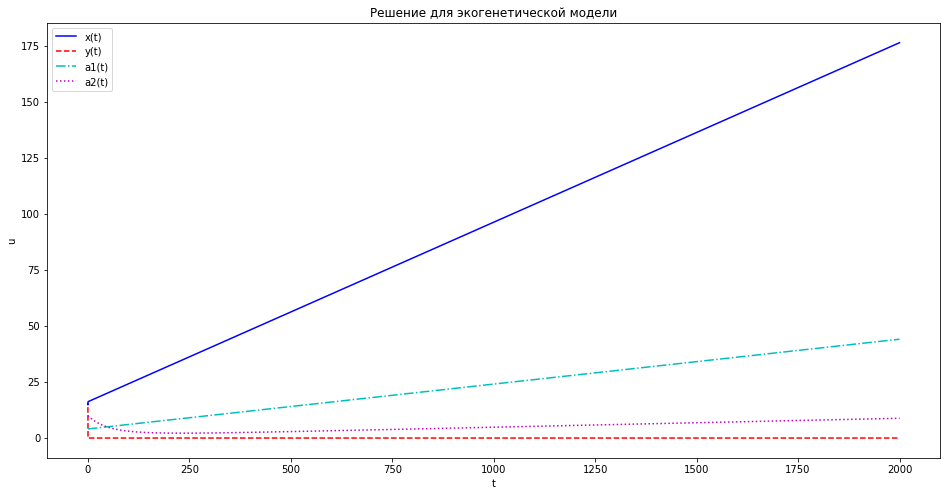

In [8]:
x0, y0, a10 = 15, 15, 4.05
cur_step = 0.001
u0 = np.array([x0, y0, a10, a20])
print(f"Начальный вектор {u0}")
print(f"Значение Tk={Tk}")
print(f"Шаг={cur_step}")

sol, t_arr = Rosenbrock3(f=f1, jacbn=jac1, u0=u0, step=cur_step)
genetic_model_plot(sol, t_arr)

#### Наблюдаем доминацию одной численности одной популяции над другой

#### Численность двух популяций зависит от взаимодействия между ними и двух медленно меняющихся генетических признаков:

\begin{equation*}

 \begin{cases}
\dot x = x(2\alpha_1 - 0,5x - \alpha_1^{3}\alpha_2^{-3}y)
\\
\dot y = y(2\alpha_2 - 0,5y - \alpha_1^{-3}\alpha_2^{3}x)
\\
\dot \alpha_1 = \varepsilon(2 - 3 \alpha_1^{2} \alpha_2^{-3}y)
\\
\dot \alpha_2 = \varepsilon(2 - 3 \alpha_1^{-3} \alpha_2^{2} x)
 \end{cases}
\end{equation*}

#### Причем параметры задачи таковы, что:
$$
\varepsilon \leq 0.01, \:\:\: 0 \leq x_0 \leq 40, \:\:\: 0 \leq y_0 \leq 40, \:\:\: \alpha_{10} \ll 1, \:\:\:, \alpha_{20} = 10
$$

In [9]:
diff_eqs2 = {"f1" : x*(2*a1 - 0.5*x - y * (a1 ** 3) * (a2 ** (-3))), 
            "f2" : y*(2*a2 - 0.5*y - x * (a2 ** 3) * (a1 ** (-3))),
            "f3" : eps*(2 - 3 * y * a1 ** (2) * a2 ** (-3)),
            "f4" : eps*(2 - 3 * x * a2 ** (2) * a1 ** (-3))
            }

X2 = Matrix([diff_eqs2["f1"], diff_eqs2["f2"], diff_eqs2["f3"], diff_eqs2["f4"]])
Y2 = Matrix([x, y, a1, a2])

J2 = X2.jacobian(Y2)
J2

Matrix([
[-a1**3*y/a2**3 + 2*a1 - 1.0*x,               -a1**3*x/a2**3, x*(-3*a1**2*y/a2**3 + 2),       3*a1**3*x*y/a2**4],
[               -a2**3*y/a1**3, 2*a2 - 1.0*y - a2**3*x/a1**3,        3*a2**3*x*y/a1**4, y*(2 - 3*a2**2*x/a1**3)],
[                            0,            -0.03*a1**2/a2**3,         -0.06*a1*y/a2**3,      0.09*a1**2*y/a2**4],
[            -0.03*a2**2/a1**3,                            0,       0.09*a2**2*x/a1**4,        -0.06*a2*x/a1**3]])

In [10]:
def f2(u_k):
    x, y, a1, a2 = u_k[0], u_k[1], u_k[2], u_k[3]

    return np.array([x*(2*a1 - 0.5*x - y * (a1 ** 3) * (a2 ** (-3))), 
                     y*(2*a2 - 0.5*y - x * (a2 ** 3) * (a1 ** (-3))),
                     eps*(2 - 3 * y * a1 ** (2) * a2 ** (-3)),
                     eps*(2 - 3 * x * a2 ** (2) * a1 ** (-3))])

def jac2(u_k):
    x, y, a1, a2 = u_k[0], u_k[1], u_k[2], u_k[3]

    return np.array([[-a1 ** 3 * y * a2 **(-3) + 2*a1 - x, -a1 ** 3 * x * a2 ** (-3), x*(-3*(a1 ** 2) * y * a2**(-3) + 2), 3*a1**3 * x * y * a2 ** (-4)], 
                     [-a2 ** 3 * y * a1 ** (-3), -a2 ** 3 * x * (a1 **(-3)) + 2*a2 - y, 3*(a2 ** 3) * x * y * a1 ** (-4), y*(-3*a2 ** 2 *x * a1**(-3) + 2)], 
                     [0, -0.03*(a1 ** 2) * a2 ** (-3), -0.06*y * a1 * a2 ** (-3), 0.09*(a1 ** 2) * y * a2 ** (-4)], 
                     [-0.03*(a2 ** 2) * a1 **(-3), 0, 0.09 * (a2 ** 2) * x * a1 ** (-4), -0.06 * x * a2 * a1 ** (-3)]])

            

Начальный вектор [20.    0.    4.05 10.  ]
Значение Tk=2000
Шаг=0.001


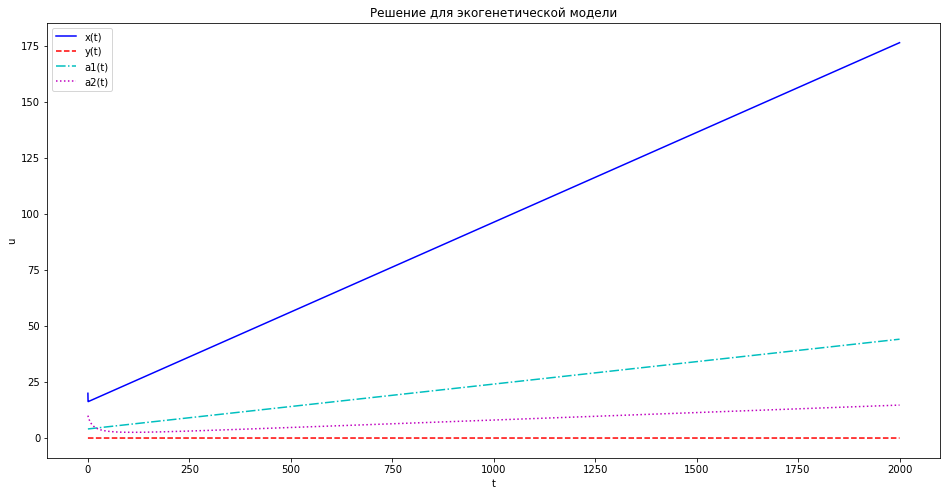

In [11]:
x0, y0, a01 = 20, 0, 4.05
cur_step = 0.001
u0 = np.array([x0, y0, a10, a20])
print(f"Начальный вектор {u0}")
print(f"Значение Tk={Tk}")
print(f"Шаг={cur_step}")

sol, t_arr = Rosenbrock3(f=f2, jacbn=jac2, u0=u0, step=cur_step)
genetic_model_plot(sol, t_arr)